# COVID-19 Literature Clustering
# (การจำแนกกลุ่มของวรรณกรรม COVID-19 แบบไม่มีผู้สอน)

# เป้าหมาย

- มีวรรณกรรมจำนวนมากที่เกี่ยวกับ COVID-19 ซึ่งเป็นเรื่องยากที่จะให้ผู้เชี่ยวชาญด้านสุขภาพนั้นติดตามข้อมูลตลอดเวลา การที่เรานั้นสามารรวบรวมกลุ่มของงานวิจัยไว้ด้วยกัน จะทำให้ผู้เชี่ยวชาญด้านสุขภาพนั้นสามารถติดตามงานที่กี่ยวข้องได้ง่ายขึ้น
- ซึ่งเราจะใช้การจัดกลุ่มเพื่อติดป้ายร่วมกับวิธีการลดมิติข้อมูล เพื่อการแสดงการรวมกลุ่มโดยการพล็อตแบบกระจาย
- อย่างไรก็ตาม เราไม่ใ่ผู้เชี่ยวชาญด้านสุขภาพ และเราก็ไม่สามารถที่จะจัดลำดับความสำคัญของวรรณกรรมนี้ได้ งานนี้เป็นเพียงเครื่องงานที่ช่วยให้ผู้เชี่ยวชาญด้านสุขภาพนั้นสามารถค้นหาวรรณกรรมได้ง่ายขึ้นเพียงเท่านั้น

# รายละเอียดชุดข้อมูล

- ทำเนียบขาวได้เตรียมข้อมูลวิจัยเปิดเกี่ยวกับ COVID-19 มากกว่า 51,000 รายการ บทความมากกว่า 40,000 รายการ
- ข้อมูลชุดนี้มีให้หรีสำหรับการวิจัยเพื่อสร้างความเข้าใจใหม่ๆ ในการรองรับกับโรคระบาดนี้
- เนื่องจากมีวรรณกรรมเป็นจำนวนมาก และเพิ่มขึ้นอย่างรวดเร็ว ซึ่งเป็นเรืื่องที่ยากสำหรับนักวิจัยสุขภาพในการติดตามงานเหล่านี้

แหล่งข้อมูล [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

# เนื้อหา

- Import Library
- Data Read
- Data Cleaning & Preprocessing
- TF-IDF Vectorization
- PCA & Clustering
- Dimensionality Reduction with t-SNE
- Topic Modeling on Each Cluster
- Classify
- Conclusion
- Citation/Sources

# Import Library

In [ ]:
# ! pip install pandarallel
# ! pip install langdetect
# ! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [2]:
import glob
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from tqdm import tqdm
from pandarallel import pandarallel

from string import punctuation
from langdetect import detect, DetectorFactory
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

plt.style.use('ggplot')

# Data Read

## Load Data from Kaggle

### เราจะใช้ kaggle commandline tools เพื่อดาวโหลดข้อมูลจากโครงการ แล้วทำการคลายไฟล์บีบอัด zip 

In [3]:
# ! kaggle datasets download allen-institute-for-ai/CORD-19-research-challenge
# ! unzip CORD-19-research-challenge.zip

## Load Metadata

### ไฟล์ metadata เป็นไฟล์ที่รวบรวม metadata ของวรรณกรรมต่างๆ ในชุดข้อมูลนี้ทั้งหมด โดยจะมีข้อมูลรายระเอียดทั่วไป เช่น id ของรรณกรรม แหล่งที่มา ลิขสิทธ์ วันที่ตีพิมพ์ ผู้เขียน ผู้ตีพิมพ์ และบทคัด่อ ซึ่งรายละเียดเพิ่มเติมเช่น เนื้อหาภายใน นั้นต้องทำการ อ่านไฟล์เพิ่มเติม

In [4]:
root_path = 'CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'

meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52398 entries, 0 to 52397
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     52398 non-null  object
 1   sha                          39024 non-null  object
 2   source_x                     52398 non-null  object
 3   title                        52240 non-null  object
 4   doi                          49058 non-null  object
 5   pmcid                        43652 non-null  object
 6   pubmed_id                    38058 non-null  object
 7   license                      52398 non-null  object
 8   abstract                     43168 non-null  object
 9   publish_time                 52390 non-null  object
 10  authors                      50119 non-null  object
 11  journal                      47156 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

## Load All JSON FileName

### ในโครงสร้างของข้อมูลที่เราใช้ เราจะต้องไต่ไดเร็กทอรี เพื่อรวมรวมชื่อไฟล์วรรณกรรมของแต่ละผู้ตีพิพม์

In [6]:
! tree -L 3

.
├── CORD-19-research-challenge
│   ├── COVID.DATA.LIC.AGMT.pdf
│   ├── biorxiv_medrxiv
│   │   └── biorxiv_medrxiv
│   ├── comm_use_subset
│   │   └── comm_use_subset
│   ├── cord_19_embeddings_4_17
│   │   └── cord_19_embeddings_4_17.csv
│   ├── custom_license
│   │   └── custom_license
│   ├── json_schema.txt
│   ├── metadata.csv
│   ├── metadata.readme
│   └── noncomm_use_subset
│       └── noncomm_use_subset
├── X_embedded.p
├── covid19.ipynb
├── df_covid.p
├── topics.txt
└── y_pred.p

10 directories, 10 files


In [7]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)

all_json.__len__()

60596

## Load All JSON Data

### สร้างคลาส FileReader เพื่อทำการอ่านไฟล์ json เข้าสู่โครงสร้างข้อมูล ดิกชั่นนารี

In [8]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [9]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### ตัวอย่างข้อข้อมูลที่อ่านได้

In [10]:
first_row = FileReader(all_json[0])

first_row

0f34670b6327305bb3d66de79d1aa96a5d8de2b2: ... Porcine reproductive and respiratory syndrome (PRRS) is an economically devastating disease in pigs causing an estimated direct loss of greater than $664 million annually to the US pork industry. 1 PR...

## Load Data To DatFrame

### ในการรวมรวมข้อมูลจากข้อมูลชนิดที่ไม่มีโครงสร้างนั้น เราต้องจัดการตรวจสอบข้อมูลทุกฟิลด์ เพื่อยืนยืนให้ได้ว่า จะสสามารถให้ข้อมูลทั้งหมดนั้เป็นข้อมูลที่มีโครงสร้างกำกับได้
### แล้วการสสร้าง DataFrame จากการสร้างข้อมูลแบบมีโครงสร้างที่ได้รวมรวมา

In [11]:
! cat {root_path}/json_schema.txt

# JSON schema of full text documents


{
    "paper_id": <str>,                      # 40-character sha1 of the PDF
    "metadata": {
        "title": <str>,
        "authors": [                        # list of author dicts, in order
            {
                "first": <str>,
                "middle": <list of str>,
                "last": <str>,
                "suffix": <str>,
                "affiliation": <dict>,
                "email": <str>
            },
            ...
        ],
        "abstract": [                       # list of paragraphs in the abstract
            {
                "text": <str>,
                "cite_spans": [             # list of character indices of inline citations
                                            # e.g. citation "[7]" occurs at positions 151-154 in "text"
                                            #      linked to bibliography entry BIBREF3
                    {
                        "start": 151,
                        "end": 1

In [12]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 60596
Processing index: 6059 of 60596
Processing index: 12118 of 60596
Processing index: 18177 of 60596
Processing index: 24236 of 60596
Processing index: 30295 of 60596
Processing index: 36354 of 60596
Processing index: 42413 of 60596
Processing index: 48472 of 60596
Processing index: 54531 of 60596
Processing index: 60590 of 60596


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,0f34670b6327305bb3d66de79d1aa96a5d8de2b2,10.2147/ijn.s59924,,Porcine reproductive and respiratory syndrome ...,"Binjawadagi, Basavaraj. Dwivedi, Varun. <br>...",An innovative approach to induce<br>cross-pro...,Int J Nanomedicine,Not provided.
1,2159d7f128a1995e7131a8d4f036fcb3cec6e332,10.1038/cddis.2014.64,Methamphetamine (METH) is a psychostimulant wi...,"J Ma 1 , J Wan 1 , J Meng 2 , S Banerjee 1 , S...","Ma, J. Wan, J. Meng, J. Banerjee, S. <br>R...",Methamphetamine induces autophagy as a<br>pro...,Cell Death Dis,Methamphetamine (METH) is a psychostimulant<b...
2,b2f0e12f8f1cb35be12a8b139547c7d570aedaf0,10.1177/2055116916668200,Case summary Herein we describe an unusual met...,A monoclonal gammopathy is identified by the p...,"Cervone, Mario. Beurlet, Stéphanie",Primary bronchial carcinoma associated with<b...,JFMS Open Rep,Case summary Herein we describe an unusual<br...
3,3230a822ceaf337c5137d32e1505878910621991,10.2174/1874357901206010151,Advances in clinical virology for detecting re...,Acute respiratory infection (ARI) of viral aet...,"Pérez-Ruiz, Mercedes. Pedrosa-Corral,<br>Ire...",Laboratory Detection of Respiratory Viruses<b...,Open Virol J,Advances in clinical virology for detecting<b...
4,c055818c61327ee072c403cb911793c9c49ca7bf,NaN,Activation of a galactosidase-specific murine ...,"I gs , the effector molecules of the immune re...",NaN,Effect of antigen/antibody ratio on<br>macrop...,J Exp Med,Activation of a galactosidase-specific<br>mur...


# Data Cleaning & Preprocessing

## Feature Engineering - Add word count columns

### สร้างฟีเจอร์ใหม่ คือจำนวนคำทั้งหมดของบทคัดย่อ, เนื้อหา และจำนวนคำที่ไม่ซ้ำกันของเนื้อหา

In [13]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body

df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0f34670b6327305bb3d66de79d1aa96a5d8de2b2,10.2147/ijn.s59924,,Porcine reproductive and respiratory syndrome ...,"Binjawadagi, Basavaraj. Dwivedi, Varun. <br>...",An innovative approach to induce<br>cross-pro...,Int J Nanomedicine,Not provided.,0,5778,1824
1,2159d7f128a1995e7131a8d4f036fcb3cec6e332,10.1038/cddis.2014.64,Methamphetamine (METH) is a psychostimulant wi...,"J Ma 1 , J Wan 1 , J Meng 2 , S Banerjee 1 , S...","Ma, J. Wan, J. Meng, J. Banerjee, S. <br>R...",Methamphetamine induces autophagy as a<br>pro...,Cell Death Dis,Methamphetamine (METH) is a psychostimulant<b...,587,4095,1410
2,b2f0e12f8f1cb35be12a8b139547c7d570aedaf0,10.1177/2055116916668200,Case summary Herein we describe an unusual met...,A monoclonal gammopathy is identified by the p...,"Cervone, Mario. Beurlet, Stéphanie",Primary bronchial carcinoma associated with<b...,JFMS Open Rep,Case summary Herein we describe an unusual<br...,131,1849,835
3,3230a822ceaf337c5137d32e1505878910621991,10.2174/1874357901206010151,Advances in clinical virology for detecting re...,Acute respiratory infection (ARI) of viral aet...,"Pérez-Ruiz, Mercedes. Pedrosa-Corral,<br>Ire...",Laboratory Detection of Respiratory Viruses<b...,Open Virol J,Advances in clinical virology for detecting<b...,198,4855,1582
4,c055818c61327ee072c403cb911793c9c49ca7bf,NaN,Activation of a galactosidase-specific murine ...,"I gs , the effector molecules of the immune re...",NaN,Effect of antigen/antibody ratio on<br>macrop...,J Exp Med,Activation of a galactosidase-specific<br>mur...,200,5580,1506


In [14]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36957 entries, 0 to 36956
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             36957 non-null  object
 1   doi                  36619 non-null  object
 2   abstract             36957 non-null  object
 3   body_text            36957 non-null  object
 4   authors              36357 non-null  object
 5   title                36921 non-null  object
 6   journal              34854 non-null  object
 7   abstract_summary     36957 non-null  object
 8   abstract_word_count  36957 non-null  int64 
 9   body_word_count      36957 non-null  int64 
 10  body_unique_words    36957 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.1+ MB


## Data Cleaning - Remove Duplicates

### ในวรรณกรรมบางงานั้น ผู้วิจัยอาาจะส่งงานวิจัยไปตีพิมพ์หลายวาราสาร ซึ่งเราสามารถลบข้อมูลที่ซ้ำกันได้ เนื่องจากเราไม่ได้สนใจกับวารสารที่ตีพิมพ์

In [15]:
df_covid['abstract'].describe(include='all')

count     36957
unique    26802
top            
freq      10098
Name: abstract, dtype: object

In [16]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     36934
unique    26802
top            
freq      10086
Name: abstract, dtype: object

In [17]:
df_covid['body_text'].describe(include='all')

count                                                 36934
unique                                                36928
top       The human disease multiple sclerosis (MS) is a...
freq                                                      2
Name: body_text, dtype: object

## Take a Look at the Data

### จะเห็นได้ว่า ยังมีบางวรรณกรรม ที่ไม่มีบทคัดย่อ

In [18]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0f34670b6327305bb3d66de79d1aa96a5d8de2b2,10.2147/ijn.s59924,,Porcine reproductive and respiratory syndrome ...,"Binjawadagi, Basavaraj. Dwivedi, Varun. <br>...",An innovative approach to induce<br>cross-pro...,Int J Nanomedicine,Not provided.,0,5778,1824
1,2159d7f128a1995e7131a8d4f036fcb3cec6e332,10.1038/cddis.2014.64,Methamphetamine (METH) is a psychostimulant wi...,"J Ma 1 , J Wan 1 , J Meng 2 , S Banerjee 1 , S...","Ma, J. Wan, J. Meng, J. Banerjee, S. <br>R...",Methamphetamine induces autophagy as a<br>pro...,Cell Death Dis,Methamphetamine (METH) is a psychostimulant<b...,587,4095,1410
2,b2f0e12f8f1cb35be12a8b139547c7d570aedaf0,10.1177/2055116916668200,Case summary Herein we describe an unusual met...,A monoclonal gammopathy is identified by the p...,"Cervone, Mario. Beurlet, Stéphanie",Primary bronchial carcinoma associated with<b...,JFMS Open Rep,Case summary Herein we describe an unusual<br...,131,1849,835
3,3230a822ceaf337c5137d32e1505878910621991,10.2174/1874357901206010151,Advances in clinical virology for detecting re...,Acute respiratory infection (ARI) of viral aet...,"Pérez-Ruiz, Mercedes. Pedrosa-Corral,<br>Ire...",Laboratory Detection of Respiratory Viruses<b...,Open Virol J,Advances in clinical virology for detecting<b...,198,4855,1582
4,c055818c61327ee072c403cb911793c9c49ca7bf,NaN,Activation of a galactosidase-specific murine ...,"I gs , the effector molecules of the immune re...",NaN,Effect of antigen/antibody ratio on<br>macrop...,J Exp Med,Activation of a galactosidase-specific<br>mur...,200,5580,1506


In [19]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,36934.000000,36934.000000,36934.000000
mean,159.876780,4657.822332,1412.721557
std,169.807121,6878.281080,1166.172257
min,0.000000,1.000000,1.000000
25%,0.000000,2325.000000,885.000000
50%,157.000000,3615.500000,1229.000000
75%,235.000000,5423.750000,1671.000000
max,4767.000000,260378.000000,38298.000000


## Data Preprocessing - Resampling

### เนื่องจากมีวรรณกรรมมากกว่า 60k และทรัพยากรทั้งเรื่องและเวลานั้นมีไม่เพียงพอ เราจึงสุ่มข้อมูลมา 10k และทำการลบวรรณกรรมที่ข้อมูลบางฟิลด์นั้นไม่มีออกไป

In [20]:
df = df_covid.sample(10000, random_state=42)
del df_covid

In [21]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9225 entries, 19142 to 18681
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             9225 non-null   object
 1   doi                  9225 non-null   object
 2   abstract             9225 non-null   object
 3   body_text            9225 non-null   object
 4   authors              9225 non-null   object
 5   title                9225 non-null   object
 6   journal              9225 non-null   object
 7   abstract_summary     9225 non-null   object
 8   abstract_word_count  9225 non-null   int64 
 9   body_word_count      9225 non-null   int64 
 10  body_unique_words    9225 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 864.8+ KB


## Data Preprocessing - Handling multiple languages

### ปัจจัยทางภาษานั้น สำคัญในการจัดการข้อมูลเกี่ยวภับข้อความ เนื่องจากแต่ละภาษามีไวยากรณ์ที่ต่างกัน ทำให้การจัดการต่างๆ ต้องแยกทำในแต่ละภาษา เราจึงดูว่า แต่ละภาษามีความถี่ของจำนวนวรรรณกรรมเท่าใดบ้าง เพื่อตัดสินใจในการทำกระบวนการต่อไป

In [22]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

for ii in tqdm(range(0,len(df))):
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        lang = detect(" ".join(text[:50]))
    except Exception as e:

        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            
            try:
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    languages.append(lang)

100%|██████████| 9225/9225 [00:41<00:00, 221.98it/s]


In [23]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 9225

{'nl': 8, 'pt': 6, 'de': 22, 'fr': 88, 'es': 81, 'af': 1, 'ca': 1, 'en': 9016, 'it': 2}


([<matplotlib.axis.XTick at 0x7f7527709080>,
 [Text(0, 0, 'nl'),
  Text(0, 0, 'pt'),
  Text(0, 0, 'de'),
  Text(0, 0, 'fr'),
  Text(0, 0, 'es'),
  Text(0, 0, 'af'),
  Text(0, 0, 'ca'),
  Text(0, 0, 'en'),
  Text(0, 0, 'it')])

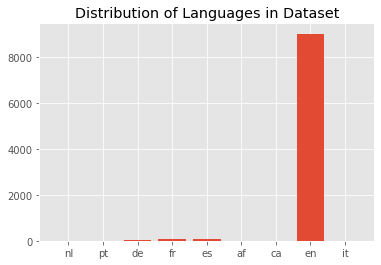

In [24]:
df['language'] = languages
plt.title("Distribution of Languages in Dataset")
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))

### จะเห็นได้ว่าวรรณกรรมส่วนใหหญ่เป็นภาษาอังกฤษ เราจึงเลือกใช้เพียงวรรณกรรมที่เป็นภาษาอังกฤษ เนื่องจาก ไม่คุ้มค่าที่จะจัดการกับภาษาที่เหลือ หริอว่า การแปลโดยใช้คอมพิวเตอร์นั้น ไม่สามารถยืนยันความถูกต้องในการแปลได้ ทำให้ความหมายอาจจะผิดไป

In [25]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9016 entries, 19142 to 18681
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             9016 non-null   object
 1   doi                  9016 non-null   object
 2   abstract             9016 non-null   object
 3   body_text            9016 non-null   object
 4   authors              9016 non-null   object
 5   title                9016 non-null   object
 6   journal              9016 non-null   object
 7   abstract_summary     9016 non-null   object
 8   abstract_word_count  9016 non-null   int64 
 9   body_word_count      9016 non-null   int64 
 10  body_unique_words    9016 non-null   int64 
 11  language             9016 non-null   object
dtypes: int64(3), object(9)
memory usage: 915.7+ KB


## Data Preprocessing - Handdle Stopwords

### ในการประความผลคำโดยใช้ความถี่ของคำ คำหยุดนัั้น เป็นคำที่มีความถี่มาก ในการนำคำหยุดมาทำการจัดกลุ่ม จะทำให้ผลลัพธ์นั้น อาจจะถูกรบกวนทำให้การจัดกลุ่มไม่ดีได้

In [26]:
stopwords = list(STOP_WORDS)

stopwords[:10]

['ours',
 'twelve',
 'until',
 'for',
 'have',
 'they',
 'after',
 '‘s',
 'one',
 'nevertheless']

In [27]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

## Data Preprocessing - Covert text to lower case, remove punctuation, stopwords

### แปลงตัวอัษรภาษาอังกฤษเป็นตัวพิมพ์เล็กทั้งหมด  ลบอักขระพิเศษ และลบคำหยุด

In [28]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuation ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [31]:
pandarallel.initialize()

df["processed_text"] = df["body_text"].parallel_apply(spacy_tokenizer)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Visualization - Body Words Count, Body Unique Words Count

### จะเห็นว่าวรรณกรรมส่วนใหญ่มีขนาดข้อความเป็นประมาณ 2000 คำ และมีจำนวนคำประมาณ 5000 คำ

count      9016.000000
mean       4556.133873
std        4812.083296
min          16.000000
25%        2471.000000
50%        3737.500000
75%        5475.500000
max      188793.000000
Name: body_word_count, dtype: float64

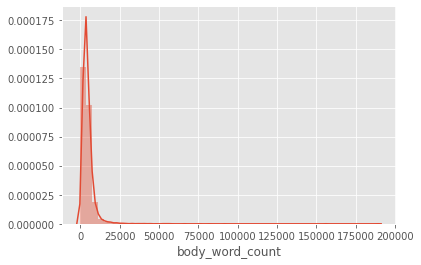

In [32]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count     9016.000000
mean      1412.140084
std        896.618501
min         15.000000
25%        931.000000
50%       1261.500000
75%       1689.000000
max      19602.000000
Name: body_unique_words, dtype: float64

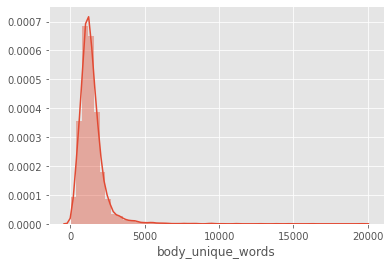

In [33]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

# TF-IDF Vectorization

### การสร้างเว็กเตอร์ของวรรณกรรมนั้น จะใช้ขนาดเว็กเตอร์ประมาณ 5000 ซึ่งแบ่งตามจำนวนคำ โดยในที่นี้ใช้ขนาดเวอกเตอร์เป็น (1, 4096)ซึ่งจะใช้อัลกอรึทึม tf-idf เพื่อคำนวณความสำคัญของแต่ละคำของแต่ละเอกสารต่อเอกสสารทั้งหมด

In [34]:
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [35]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(9016, 4096)

# PCA & Clustering

### เราสามารถลดขนาดข้อมูลโดยที่ยังไม่สูษเสียความแปรปวนของข้อมูลและลดสิ่งรบกวน (ข้อมูลที่แตกต่างจากข้อมูลอื่นๆ ที่ส่งผลต่อการเรียนรู้) ซึ่งใช้เทคนิกการวิเคราห์องค์ประกอบ กับข้อมูลเวกเตอร์

In [36]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())

X_reduced.shape

(9016, 2111)

## Elbow Method

### ในการเลือกว่า อัลกอรึทึม K-means นั้นควรใช้ค่า K เท่าไหรดี นั้นใช้หลักการ Elbow มาทำการคัดเลือก โดยดูจากผลรวมของระยะทางยกกำลังสองของแต่ละจุดถึงจุดศูนย์กลางของแต่ละกลุ่มที่ปรับค่าแล้ว โดยเลือกค่า k ที่ 20 เนื่องจากความชันของระยะทางต่อจำนวนกลุ่มที่เพิ่มมขึ้นนั้น เริ่มไม่มีนัยยะสำคัญแล้ว

In [40]:
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    k_means.fit(X_reduced)

    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 2 clusters
Found distortion for 3 clusters
Found distortion for 4 clusters
Found distortion for 5 clusters
Found distortion for 6 clusters
Found distortion for 7 clusters
Found distortion for 8 clusters
Found distortion for 9 clusters
Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters
Found distortion for 30 clusters
Found distortion for 31 clusters
Found distortion f

Text(0, 0.5, 'Distortion')

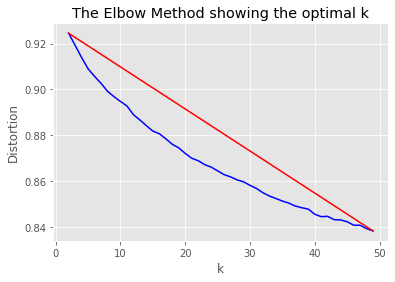

In [41]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.title('The Elbow Method showing the optimal k')
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')

## Run k-means with K=20

In [42]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

In [44]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42, n_jobs=-1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 9016 samples in 5.393s...
[t-SNE] Computed neighbors for 9016 samples in 67.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9016
[t-SNE] Computed conditional probabilities for sample 2000 / 9016
[t-SNE] Computed conditional probabilities for sample 3000 / 9016
[t-SNE] Computed conditional probabilities for sample 4000 / 9016
[t-SNE] Computed conditional probabilities for sample 5000 / 9016
[t-SNE] Computed conditional probabilities for sample 6000 / 9016
[t-SNE] Computed conditional probabilities for sample 7000 / 9016
[t-SNE] Computed conditional probabilities for sample 8000 / 9016
[t-SNE] Computed conditional probabilities for sample 9000 / 9016
[t-SNE] Computed conditional probabilities for sample 9016 / 9016
[t-SNE] Mean sigma: 0.379101
[t-SNE] KL divergence after 50 iterations with early exaggeration: 81.252281
[t-SNE] KL divergence after 1000 iterations: 1.817471


Text(0.5, 1.0, 't-SNE with no Labels')

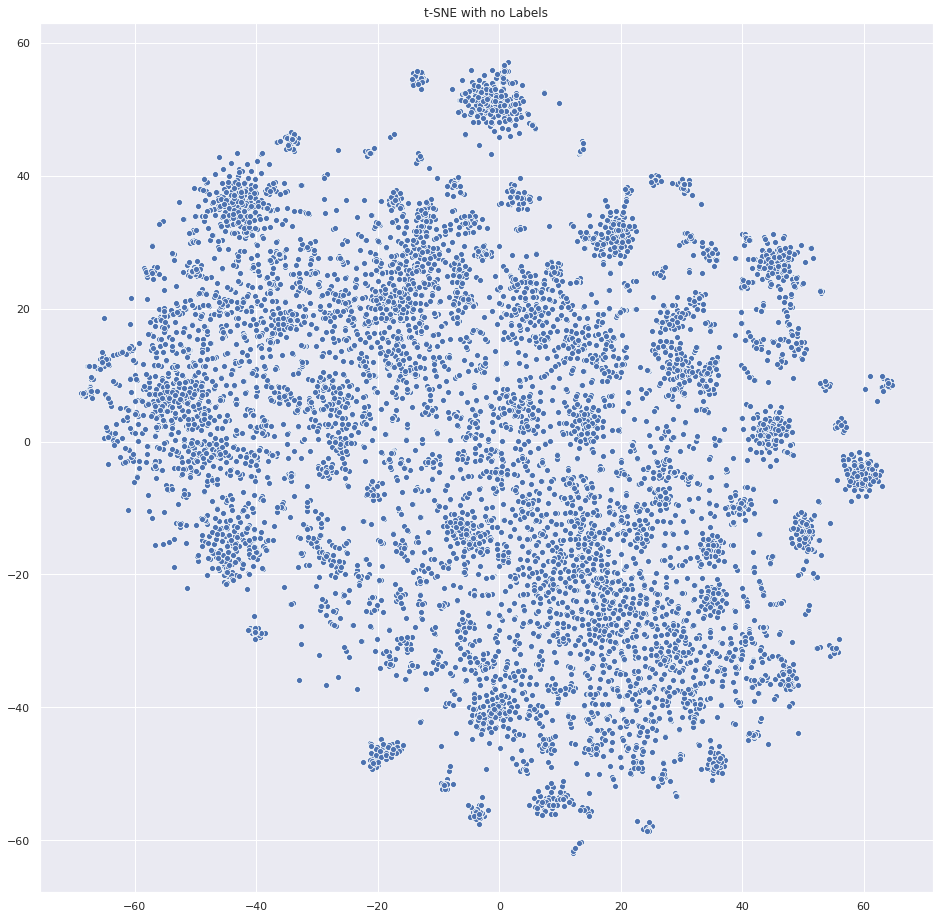

In [45]:
sns.set(rc={'figure.figsize':(16,16)})

palette = sns.color_palette("bright", 1)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')

Text(0.5, 1.0, 't-SNE with Kmeans Labels')

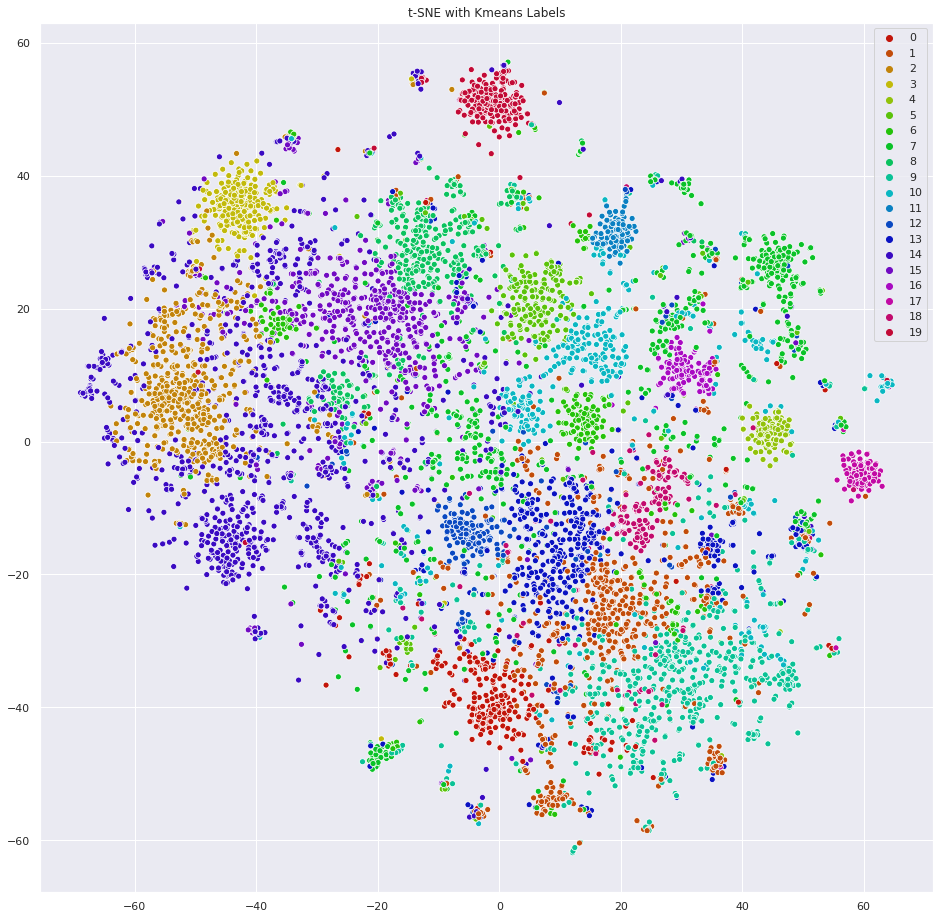

In [46]:
sns.set(rc={'figure.figsize':(16,16)})

palette = sns.hls_palette(20, l=.4, s=.9)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')

# Topic Modeling on Each Cluster

In [47]:
vectorizers = []
    
for ii in range(0, 20):
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    
vectorizers[0]    

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [48]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
vectorized_data.__len__()

20

In [49]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [50]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


## Functions for printing keywords for each topic

In [51]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [53]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [54]:
all_keywords[0][:10]

['bind',
 'reaction',
 'protein',
 'derivative',
 'infection',
 'plant',
 'acid',
 'assay',
 'yield',
 'concentration']

In [55]:
len(all_keywords)

20

In [56]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [57]:
# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

# Classify

In [58]:
def classification_report(model_name, test, pred):
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

X_train.shape[0], X_test.shape[0]

(7212, 1804)

In [60]:
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train)

sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  88.741 %
     Precision:  90.578 %
        Recall:  90.329 %
      F1 score:  90.420 %


In [61]:
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)

classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  85.477 %
     Precision:  89.354 %
        Recall:  87.140 %
      F1 score:  88.145 %


In [62]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 90.450 %


# You can find the full version of the interactive plot here on GitHub:

[https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html](https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
)

Because of its size, a sparse version is produced in this Notebook. 

# Conclusion

- ในโครงการนี้เราได้ใช้การจัดกลุ่มแบบไม่มีผู้สอนในการจัดกลุ่มวรรณกรรม โดยมีกระบวนทำความสะอาดข้อมูลประเภทลำดับข้อความ และการลดมิติข้อมูล เพื่อการพล็อตภาพแบบกระจาย เพื่อความสะดวกในการอ่านวรรณกรรมที่เกี่ยวข้อง ซึ่งจะถูกจัดกลุ่มไว้เข้าด้วยกัน ทำให้นักวิจัยสุขภาพสามารถติดตามววรณกรรมได้ดียิ่งขึ้น
- การจัดกลุ่มนี้ใช้เทคนิกการจัดกลุ่มข้อมูลแบบไม่มีผู้าสอนด้วยวิธี K-Means โดยใช้จำนวนกลุ่มเป็น 20 กลุ่ม ที่ได้จากการผ่านกระบวนการ Ebow แล้วใช้เทคนิก LDA เพื่อหาคำที่สำคัญของแต่ลละกลุ่ม ซึ่งทำมห้สะดวกต่อการค้นหาโดยผู้เชี่ยวชาญด้านสุขภาพ
- เราใช้ K-Means เพื่อทำการแบ่งกลุ่ม และใช้ t-SNE เพื่อการพล็อตแบบกระจาย ซึ่งโดยหลักกการ ข้อความที่มีเนื้อหาใกล้กันควรจะถูกจัดกลุ่มไว้ในที่ใกล้ๆ กัน และควรมีฉลากเหมือนกัน แต่อย่างไรก็ตาม เนื่องจากเป็นการจัดกลุ่มนี้น อาจจะถูกพิจารณาด้วยความคล้ายที่แตกต่างหัร ทำให้อาจจะมีผลต่อการตัดสินใจในการแบ่งกลุ่ม
- เพราะว่าเป็นการเรียนรู้แบบไม่มีผู้สสอน จึงไม่สามารถยืนยันความถูกต้องของการแบ่งกลุ่มได้สมบูรณ์ ซึ่งเราต้องพิจารณาว่า แต่ละกลุ่มที่ถูกแบ่งนั้น มีความถูกต้องจริงๆ ซึ่งเราใช้ชื่อหัวข้อ บทคัดย่อ ในการการจำแนกเป็นแต่ลละกลุ่ม แล้วใช้การจัดกลุ่มแบบมีผู้สอนโดยใช้เทคนิก SGD อีกทีหนึ่ง เพื่อแสดงให้เห็นว่าเป็นดดารจัดกลุ่ม ที่สามารถให้ประสิทธฺภาพที่อัลกอรึทึมอื่นๆ สามารถทำซ้ำและให้ผลลัพธ์ที่ดี

# Citation/Sources

```
@inproceedings{COVID-19 Literature Clustering,
    author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
    title = {COVID-19 Literature Clustering},
    year = {2020},
    month = {April},
    location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
    note={Malware Research Group},
    url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
}
```